# Automated Photo Editing using Neural Style Transfer

## Section x: Previous Methods

#### (This section and all its subsections are written by Tanav Shah (ts3469))

Neural Style Transfer has a large number of applications in the computer vision domain. However, it is far less explored to edit images and produce professionally edited like images from their raw forms. The previous works merely list editing images as a benefit of their modules, but not many deliberate efforts have been put in to apply neural style transfer for editing images.

There are a few research papers that work around using style transfer for specific vision applications, and there are others that build modules for general style transfer between any two types of images. For our use case, we mainly explored the second type of method because the others are highly tuned for a specific task. We use the Deep Photo Style Transfer by Fujun Luan et al. as our base method for this project, make novel changes to improve their style transfer procedure, and build an additional module that automatically selects the best style image from our curated dataset to edit the given input image. This is an end-to-end pipeline and takes as input just the input image and input segmentation files to generate the edited stylized image.

#### Deep Photo Style Transfer (DPST):

DPST is a generative algorithm. The algorithm takes two images as input, the input image, and the reference style image. The model aims to transfer the style of the reference image to the input image with photo realism while preserving its overall structure. This algorithm is built over the method proposed by Gatys et al. in their work "Image Style Transfer Using Convolutional Neural Networks." 

Suppose we have a style image S and an input image I, and we want to produce an output image O. The objective function they use to minimize is given by: ![alt text](equation_1.png) Here L is the total number of convolutional layers. There are Nl number of filters in each layer, with a vectorized feature map of size Dl. The weights alpha and beta are weights for each layer, and lambda balances the amount of style to be transferred. Fl is a feature matrix, and Gl is the gram matrix defined as the inner product between the vectorized feature maps. 

DPST adds a photorealism regularization term which helps to preserve the structure of the input image and produce photorealistic output images. This idea is the first and very efficient attempt at this problem. They assume that the input image is already photorealistic and then ensure that during their process, they do not lose this property. For this, they add a component to the loss term called affine loss. This term uses Matting Laplacian matrices, first introduced and used by Levin et al. in "A closed-form solution
to natural image matting." This is given by: ![alt text](equation_2.png) We skip the further mathematical details of this part in the report, which are mentioned in great detail in the paper. 

The method by Gatys et al. uses a style term in the loss, but it has its limitations. This term uses a Gram matrix computed over the entire image, which encodes the exact distribution of the neural responses from the image. This makes the Gram matrix incapable of adapting to variations in the context and often leads to spillovers. To address this, DPST uses the segmentations of the input and style images to generate segmentation masks and use these as additional channels. The style loss component is then summed over all these channels. The computation of the Gram matrix still happens in the same way but on different inputs. 

Finally, all these three components of the loss function are added to compute the overall loss. DPST uses a pre-trained VGG-19 model for feature extraction from the input images. The output of conv4_2 (2nd convolutional layer of the 4th block of VGG) is used as the content representation, and the outputs of conv1_1, conv2_1, conv3_1, conv4_1, and conv5_1 are used for style representations. 

The output image is initialized to a random noise of the same dimension as the required output. Using SGD and Adam optimizer, the pixels of this resultant image is updated over iterations using the loss from the work by Gatys. This image is saved as intermediate output. Again, taking this intermediate image as input, the same process is repeated, but this time with the new updated loss function from DPST. This final image is returned as the output. 

#### Comparison of DPST with other methods:

The older methods, such as the one from Gatys et al., work well but still cannot handle the case of spillovers as described in the previous section. Another such transfer method is “Color transfer between images” by E. Reinhard et al. They used the idea of global color transformation to affect the image colors strongly, but not have any impact on the image structure. This method, however, has limited capabilities because it cannot model spatially varying effects and, thus, cannot faithfully transfer the style of the second image. These limitations are effectively addressed by DPST.

A few more recent works, such as "Photorealistic Style Transfer via Wavelet Transforms" by Jaejun Yoo et al., attempt the style transfer problem differently. They propose their own end-to-end model, called WCT2. This model also uses VGG-19 for feature extraction but has its own architecture involving wavelet pooling, unpooling layers. Instead of the output image being generated over iterations, WCT2 employs a progressive stylization strategy to generate the output in a single pass. There are also a few variations of the WCT2 model discussed in the paper, but they do not significantly outperform the DPST method. Another paper on "Arbitrary Style Transfer with Deep Feature Reshuffle" by Shuyang Gu et al. shuffles the feature maps of the images to connect their defined global and local style losses to generate output images.

Though these methods perform slightly better than DPST, they are not very useful in our scenario. These are end-to-end pipelines and therefore do not provide an explicit option to control the amount of style to be transferred. These methods generate the output image directly using their loss function and architectures. This leads to good artistic images, but we want to control the amount of style from the professionally edited style image to be transferred to the raw input image to be edited. This is why we used DPST as our base method for this project.

## Section x: Our novel changes and implementation details:

#### (This section and all its subsections are written by Tanav Shah (ts3469).)
#### The implementations and integrations of all the techniques decribed here are done by me. I developed these modifications from novel ideas and discussed with my teammates.

The code from the authors of DPST was implemented in an older version of python and Tensorflow version 1 and had several incompatibility issues. I worked around these to upgrade the complete code to Tensorflow version 2.4.1 and python 3.8. Making the exact versions of TensorFlow, Keras, NumPy, pillow, python, scipy, etc., compatible with each other and getting the code base running was in itself a huge challenge which took several hours to get executable. 

The DPST method uses the VGG-19 model for feature extraction, as described in the previous section. Since we know that Resnet performs better for the classification task, I tried extracting the feature vectors using Resnet. Still, the final output images could not faithfully transfer the style of the reference image. In some cases, the structure of the input image also got distorted somewhat more as compared to VGG. On reading more about this, I got to know that VGGs have inherent stability and inability to learn non-robust features of images, which makes them the best choice for feature extractor for our use case.

The code from the authors of DPST uses a pre-trained VGG model on a dataset different from imagenet. Therefore, I changed this part to use the pre-trained VGG-19 model from Tensorflow on imagenet. This model architecture was slightly different from the ones the authors used, so I made several changes in the styling method to adapt to these. This VGG from TensorFlow is optimized for the classification task, which is significantly different from our use case. Therefore, I decided to use transfer learning, as discussed in the lectures and homework assignments, to make the VGG-19 model adapt to our use case of style transfer. 

The VGG-19 model has the last two layers as fully connected layers and a 1000 class prediction layer. I modified these to be a fully-connected layer with 1024 hidden units and the final layer as a 3-class prediction layer using softmax. These three classes it predicts are from our newly curated dataset, namely, portraits, landscape, and wildlife. Apart from these last two layers, all other model layers are frozen for training, and the model is trained for five epochs on our newly curated dataset. Next, all layers are unfrozen, and the complete model is trained again on the same data. This transfer learning technique helped the VGG-19 model to get fine-tuned to our use case of image style transfer on our data. This newly trained model is then saved so that the training does not need to be done every time we want to edit an image. With this transfer-learned model, I achieved more stable images with slightly fewer distortions on the same input and reference style images. That is why we proceeded with this model. 

DPST uses three components for the loss function described in the previous section. I decided to add a new component to this loss function, which I thought about and implemented from scratch. The features extracted from the images using our new VGG-19 model are the combinations of outputs of certain model layers. These feature vectors are used to compute the loss component value. I consider the different elements of these feature vectors to be different dimensions. Therefore, flattening these feature values gives us a vector in some n-dimension space, where n is the number of feature values extracted. This is a positional vector considering the origin to have all zero values. We obtain such vectors for the features of input and style images. Next, we compute the cosine of the angle between these two vectors using the dot product. We want the features extracted to be aligned together and therefore want this angle to be as small as possible. The intuition is that since we are starting from a random noise image, we want this image to be aligned with the style image features. I did not directly use the images and used the extracted features because the previous case would result in the output image getting very, very close to the style image, which is not ideal. Since this is a component of the loss function, I use the reciprocal of cosine (sec) as the loss component value. To summarize, the function computes the norm of the two feature maps and their sum of element-wise products. The multiplication of both norms is divided by this sum to obtain the loss component value. 

Combining all these novel additions to the DPST model, we achieved better results. The output images had slightly fewer distortions and were more structurally similar to the input image, still faithfully having the style of the reference image.


## Section x.1: Complete Code and Working demo

#### (This code in this section is compiled and implemented by Tanav Shah (ts3469)).
#### We used DPST's code as our base code for style transfer and made the modifications discussed above. I first made several changes to this base code to get it running in its raw form, then implemented the novel changes for style transfer.

In [1]:
from __future__ import division, print_function
import argparse
from PIL import Image
import numpy as np
import os
import pandas as pd
from PIL import Image

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import time
import math
from functools import partial
import copy
import os

import scipy.misc as spm
import scipy.ndimage as spi
import scipy.sparse as sps

import scipy.optimize as sopt
from keras.models import Model

import inspect

2022-12-09 19:44:35.058149: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [2]:
try:
    xrange
except NameError:
    xrange = range

VGG_MEAN = [103.939, 116.779, 123.68]

# List of arguments that are used in the code. These can be modified to change certain parameters while
# executing the code

arguments = {}

arguments["content_image_path"] = "./examples/input/in11.png"
arguments["style_image_path"] = "./examples/style/tar11.png"
arguments["content_seg_path"] = "./examples/segmentation/in11.png"
arguments["style_seg_path"] = "./examples/segmentation/tar11.png"
arguments["init_image_path"] = ""
arguments["output_image"] = "best_stylized.png"
arguments["serial"] = './'
arguments["max_iter"] = 1000
arguments["learning_rate"] = 1.0
arguments["print_iter"] = 1
arguments["save_iter"] = 100
arguments["lbfgs"] = False
arguments["content_weight"] = 5e0
arguments["style_weight"] = 1e2
arguments["tv_weight"] = 1e-3
arguments["affine_weight"] = 1e4
arguments["custom_loss_weight"] = 1e-4
arguments["style_option"] = 2
arguments["apply_smooth"] = False
arguments["f_radius"] = 15
arguments["f_edge"] = 1e-1

In [3]:
"""
The code by the authors use a pre-trained version of the VGG19 model. We change this model to the Tensorflow's
VGG19 model pre-trained on the imagenet dataset. The network architecture is changed and the model is tranfer
learned on our newly curated data.

The last 2 layers are changed in the VGG19 model. These layers are noe set to be fully-connected layer having
1024 hidden units, followed by a softmax prediction layer having 3 classes as outputs from our dataset. This
network is first freezed and only the last 2 layers are trained on our new dataset. Then, the whole model
is unfreezed and trained again on the new dataset. This newly transfer learned VGG19 model is then passed to
the stylize method for style transfer.
"""

# Load the VGG19 model

vgg_model = tf.keras.applications.vgg19.VGG19(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

vgg_model.layers[1]._name = "conv1_1"
vgg_model.layers[2]._name = "conv1_2"
vgg_model.layers[3]._name = 'pool1'

vgg_model.layers[4]._name = "conv2_1"
vgg_model.layers[5]._name = "conv2_2"
vgg_model.layers[6]._name = 'pool2'

vgg_model.layers[7]._name = "conv3_1"
vgg_model.layers[8]._name = "conv3_2"
vgg_model.layers[9]._name = "conv3_3"
vgg_model.layers[10]._name = "conv3_4"
vgg_model.layers[11]._name = 'pool3'

vgg_model.layers[12]._name = "conv4_1"
vgg_model.layers[13]._name = "conv4_2"
vgg_model.layers[14]._name = "conv4_3"
vgg_model.layers[15]._name = "conv4_4"
vgg_model.layers[16]._name = 'pool4'

vgg_model.layers[17]._name = "conv5_1"
vgg_model.layers[18]._name = "conv5_2"
vgg_model.layers[19]._name = "conv5_3"
vgg_model.layers[20]._name = "conv5_4"
vgg_model.layers[21]._name = 'pool5'

inputs = vgg_model.input
x = inputs

# Change the network architecture

for layer in vgg_model.layers:
    if layer._name == "fc2":
        x = tf.keras.layers.Dense(1024, activation='relu', name='fc2')(x)
    elif layer._name == "predictions":
        x = tf.keras.layers.Dense(3, activation='softmax', name='predictions')(x)
    else:
        x = layer(x)
        layer.trainable = False

vgg_model = tf.keras.Model(inputs, x)

print(vgg_model.summary())

# set the data

x_train = []
y_train = []

# portraits
for i in range(129):
    y_train.append(0)
    image_path = "new_dataset/portraits/" + str(i + 1) + ".jpg"
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))
    img = np.array(img)
    x_train.append(img)

# landscape
for i in range(135):
    y_train.append(1)
    image_path = "new_dataset/landscape/" + str(i + 1) + ".jpg"
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))
    img = np.array(img)
    x_train.append(img)

# wildlife
for i in range(136):
    y_train.append(2)
    image_path = "new_dataset/wildlife/" + str(i + 1) + ".jpg"
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)
y_train = np.array(y_train)

print(x_train.shape, y_train.shape)

# freeze and train the model

vgg_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy())
history = vgg_model.fit(x_train, y_train, batch_size=20, epochs=5)

# Unfreeze and train again

print("Unfreeze the whole model, training again:")

for layer in vgg_model.layers:
    layer.trainable = True

vgg_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy())

print(vgg_model.summary())

history = vgg_model.fit(x_train, y_train, batch_size=20, epochs=5)

# Save trained VGG model
vgg_model.save("vgg_model")

# Load trained VGG model
vgg_model = tf.keras.models.load_model("vgg_model")

arguments["vgg_model"] = vgg_model

2022-12-09 19:44:51.463029: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-12-09 19:44:52.088762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 19:44:52.088965: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-12-09 19:44:52.089010: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-12-09 19:44:52.115676: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-12-09 19:44:52.130106: I tensorflow/stream_executor/plat

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1:0
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            multiple             0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 224, 224, 64) 1792        input_1[1][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 224, 224, 64) 36928       conv1_1[1][0]                    
_______________________________

2022-12-09 19:45:13.441200: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-12-09 19:45:14.435863: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.8


400/400 [==============================] - 1s 3ms/sample - loss: 5.5868
Epoch 2/5
400/400 [==============================] - 1s 3ms/sample - loss: 5.6510
Epoch 3/5
400/400 [==============================] - 1s 3ms/sample - loss: 5.5608
Epoch 4/5
400/400 [==============================] - 1s 3ms/sample - loss: 5.5620
Epoch 5/5
400/400 [==============================] - 1s 3ms/sample - loss: 5.5607
Unfreeze the whole model, training again:
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            multiple             0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 224, 224, 64) 1792        input_1[1][0]                    
_________________________________________

In [4]:
"""
This cell has various helper functions which are used at different times in the code.
"""

# Convert RGB image to BGR format

def rgb2bgr(rgb, vgg_mean=True):
    if vgg_mean:
        return rgb[:, :, ::-1] - VGG_MEAN
    else:
        return rgb[:, :, ::-1]
    
# Convert BGR image to RGB format

def bgr2rgb(bgr, vgg_mean=False):
    if vgg_mean:
        return bgr[:, :, ::-1] + VGG_MEAN
    else:
        return bgr[:, :, ::-1]

# Load the segmentation data    

def load_seg(content_seg_path, style_seg_path, content_shape, style_shape):
    color_codes = ['BLUE', 'GREEN', 'BLACK', 'WHITE', 'RED', 'YELLOW', 'GREY', 'LIGHT_BLUE', 'PURPLE']
    def _extract_mask(seg, color_str):
        h, w, c = np.shape(seg)
        if color_str == "BLUE":
            mask_r = (seg[:, :, 0] < 0.1).astype(np.uint8)
            mask_g = (seg[:, :, 1] < 0.1).astype(np.uint8)
            mask_b = (seg[:, :, 2] > 0.9).astype(np.uint8)
        elif color_str == "GREEN":
            mask_r = (seg[:, :, 0] < 0.1).astype(np.uint8)
            mask_g = (seg[:, :, 1] > 0.9).astype(np.uint8)
            mask_b = (seg[:, :, 2] < 0.1).astype(np.uint8)
        elif color_str == "BLACK":
            mask_r = (seg[:, :, 0] < 0.1).astype(np.uint8)
            mask_g = (seg[:, :, 1] < 0.1).astype(np.uint8)
            mask_b = (seg[:, :, 2] < 0.1).astype(np.uint8)
        elif color_str == "WHITE":
            mask_r = (seg[:, :, 0] > 0.9).astype(np.uint8)
            mask_g = (seg[:, :, 1] > 0.9).astype(np.uint8)
            mask_b = (seg[:, :, 2] > 0.9).astype(np.uint8)
        elif color_str == "RED":
            mask_r = (seg[:, :, 0] > 0.9).astype(np.uint8)
            mask_g = (seg[:, :, 1] < 0.1).astype(np.uint8)
            mask_b = (seg[:, :, 2] < 0.1).astype(np.uint8)
        elif color_str == "YELLOW":
            mask_r = (seg[:, :, 0] > 0.9).astype(np.uint8)
            mask_g = (seg[:, :, 1] > 0.9).astype(np.uint8)
            mask_b = (seg[:, :, 2] < 0.1).astype(np.uint8)
        elif color_str == "GREY":
            mask_r = np.multiply((seg[:, :, 0] > 0.4).astype(np.uint8),
                                 (seg[:, :, 0] < 0.6).astype(np.uint8))
            mask_g = np.multiply((seg[:, :, 1] > 0.4).astype(np.uint8),
                                 (seg[:, :, 1] < 0.6).astype(np.uint8))
            mask_b = np.multiply((seg[:, :, 2] > 0.4).astype(np.uint8),
                                 (seg[:, :, 2] < 0.6).astype(np.uint8))
        elif color_str == "LIGHT_BLUE":
            mask_r = (seg[:, :, 0] < 0.1).astype(np.uint8)
            mask_g = (seg[:, :, 1] > 0.9).astype(np.uint8)
            mask_b = (seg[:, :, 2] > 0.9).astype(np.uint8)
        elif color_str == "PURPLE":
            mask_r = (seg[:, :, 0] > 0.9).astype(np.uint8)
            mask_g = (seg[:, :, 1] < 0.1).astype(np.uint8)
            mask_b = (seg[:, :, 2] > 0.9).astype(np.uint8)
        return np.multiply(np.multiply(mask_r, mask_g), mask_b).astype(np.float32)

    # PIL resize has different order of np.shape
    content_seg = np.array(Image.open(content_seg_path).convert("RGB").resize(content_shape, resample=Image.BILINEAR), dtype=np.float32) / 255.0
    style_seg = np.array(Image.open(style_seg_path).convert("RGB").resize(style_shape, resample=Image.BILINEAR), dtype=np.float32) / 255.0

    color_content_masks = []
    color_style_masks = []
    for i in xrange(len(color_codes)):
        color_content_masks.append(tf.expand_dims(tf.expand_dims(tf.constant(_extract_mask(content_seg, color_codes[i])), 0), -1))
        color_style_masks.append(tf.expand_dims(tf.expand_dims(tf.constant(_extract_mask(style_seg, color_codes[i])), 0), -1))

    return color_content_masks, color_style_masks

# Compute the gram matrix from the paper

def gram_matrix(activations):
    height = tf.shape(activations)[1]
    width = tf.shape(activations)[2]
    num_channels = tf.shape(activations)[3]
    gram_matrix = tf.transpose(activations, [0, 3, 1, 2])
    gram_matrix = tf.reshape(gram_matrix, [num_channels, width * height])
    gram_matrix = tf.matmul(gram_matrix, gram_matrix, transpose_b=True)
    return gram_matrix

# Helper function to compute the Laplacian matrix

def getlaplacian1(i_arr, consts, epsilon=1e-5, win_rad=1):
    neb_size = (win_rad * 2 + 1) ** 2
    h, w, c = i_arr.shape
    img_size = w * h
    consts = spi.morphology.grey_erosion(consts, footprint=np.ones(shape=(win_rad * 2 + 1, win_rad * 2 + 1)))

    indsM = np.reshape(np.array(range(img_size)), newshape=(h, w), order='F')
    tlen = int((-consts[win_rad:-win_rad, win_rad:-win_rad] + 1).sum() * (neb_size ** 2))
    row_inds = np.zeros(tlen)
    col_inds = np.zeros(tlen)
    vals = np.zeros(tlen)
    l = 0
    for j in range(win_rad, w - win_rad):
        for i in range(win_rad, h - win_rad):
            if consts[i, j]:
                continue
            win_inds = indsM[i - win_rad:i + win_rad + 1, j - win_rad: j + win_rad + 1]
            win_inds = win_inds.ravel(order='F')
            win_i = i_arr[i - win_rad:i + win_rad + 1, j - win_rad: j + win_rad + 1, :]
            win_i = win_i.reshape((neb_size, c), order='F')
            win_mu = np.mean(win_i, axis=0).reshape(c, 1)
            win_var = np.linalg.inv(
                np.matmul(win_i.T, win_i) / neb_size - np.matmul(win_mu, win_mu.T) + epsilon / neb_size * np.identity(
                    c))

            win_i2 = win_i - np.repeat(win_mu.transpose(), neb_size, 0)
            tvals = (1 + np.matmul(np.matmul(win_i2, win_var), win_i2.T)) / neb_size

            ind_mat = np.broadcast_to(win_inds, (neb_size, neb_size))
            row_inds[l: (neb_size ** 2 + l)] = ind_mat.ravel(order='C')
            col_inds[l: neb_size ** 2 + l] = ind_mat.ravel(order='F')
            vals[l: neb_size ** 2 + l] = tvals.ravel(order='F')
            l += neb_size ** 2

    vals = vals.ravel(order='F')[0: l]
    row_inds = row_inds.ravel(order='F')[0: l]
    col_inds = col_inds.ravel(order='F')[0: l]
    a_sparse = sps.csr_matrix((vals, (row_inds, col_inds)), shape=(img_size, img_size))

    sum_a = a_sparse.sum(axis=1).T.tolist()[0]
    a_sparse = sps.diags([sum_a], [0], shape=(img_size, img_size)) - a_sparse

    return a_sparse

# Function to compute the Laplacian matrix

def getLaplacian(img):
    h, w, _ = img.shape
    coo = getlaplacian1(img, np.zeros(shape=(h, w)), 1e-5, 1).tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

In [5]:
# VGG19 helper class from the paper

class Vgg19_helper:
    def __init__(self, vgg19_npy_path=None):
        if vgg19_npy_path is None:
            path = "vgg19.npy"
            vgg19_npy_path = path
        
        self.data_dict = np.load(vgg19_npy_path, encoding='latin1', allow_pickle=True).item()

    def build(self, bgr, clear_data=True):
        """
        load variable from npy to build the VGG
        """
        self.conv1_1 = self.conv_layer(bgr, "conv1_1")
        self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
        self.pool1 = self.max_pool(self.conv1_2, 'pool1')

        self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
        self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
        self.pool2 = self.max_pool(self.conv2_2, 'pool2')

        self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
        self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
        self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
        self.conv3_4 = self.conv_layer(self.conv3_3, "conv3_4")
        self.pool3 = self.max_pool(self.conv3_4, 'pool3')

        self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
        self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
        self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
        self.conv4_4 = self.conv_layer(self.conv4_3, "conv4_4")
        self.pool4 = self.max_pool(self.conv4_4, 'pool4')

        self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")

        if clear_data:
            self.data_dict = None

    def get_all_layers(self):
        return [self.conv1_1, self.conv1_2, self.pool1,\
                self.conv2_1, self.conv2_2, self.pool2, \
                self.conv3_1, self.conv3_2, self.conv3_3, self.conv3_4, self.pool3, \
                self.conv4_1, self.conv4_2, self.conv4_3, self.conv4_4, self.pool4, \
                self.conv5_1]

    def avg_pool(self, bottom, name):
        return tf.nn.avg_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def max_pool(self, bottom, name):
        return tf.nn.max_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def conv_layer(self, bottom, name):
        with tf.variable_scope(name):
            filt = self.get_conv_filter(name)
            conv = tf.nn.conv2d(bottom, filt, [1, 1, 1, 1], padding='SAME')

            conv_biases = self.get_bias(name)
            bias = tf.nn.bias_add(conv, conv_biases)

            relu = tf.nn.relu(bias)
            return relu

    def get_conv_filter(self, name):
        return tf.constant(self.data_dict[name][0], name="filter")

    def get_bias(self, name):
        return tf.constant(self.data_dict[name][1], name="biases")

In [6]:
"""
This cell defines all the loss functions we are using in the model. The content loss, style loss and the total
variation loss are as used in the paper. Our novel component of the loss function, which we described earlier
is computed through the custom_loss method.
"""

def content_loss(const_layer, var_layer, weight):
    print(const_layer)
    print(var_layer)
    return tf.reduce_mean(tf.squared_difference(const_layer, var_layer)) * weight

def style_loss(CNN_structure, const_layers, var_layers, content_segs, style_segs, weight):
    loss_styles = []
    layer_count = float(len(const_layers))
    layer_index = 0

    _, content_seg_height, content_seg_width, _ = content_segs[0].get_shape().as_list()
    _, style_seg_height, style_seg_width, _ = style_segs[0].get_shape().as_list()

    for layer_name in CNN_structure:
        layer_name = layer_name[layer_name.find("/") + 1:]

        # downsampling segmentation

        if "pool" in layer_name:
            content_seg_width, content_seg_height = int(math.ceil(content_seg_width / 2)), int(math.ceil(content_seg_height / 2))
            style_seg_width, style_seg_height = int(math.ceil(style_seg_width / 2)), int(math.ceil(style_seg_height / 2))

            for i in xrange(len(content_segs)):
                content_segs[i] = tf.image.resize_bilinear(content_segs[i], tf.constant((content_seg_height, content_seg_width)))
                style_segs[i] = tf.image.resize_bilinear(style_segs[i], tf.constant((style_seg_height, style_seg_width)))

        elif "conv" in layer_name:
            for i in xrange(len(content_segs)):
                # have some differences on border with torch
                content_segs[i] = tf.nn.avg_pool(tf.pad(content_segs[i], [[0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT"), \
                ksize=[1, 3, 3, 1], strides=[1, 1, 1, 1], padding='VALID')
                style_segs[i] = tf.nn.avg_pool(tf.pad(style_segs[i], [[0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT"), \
                ksize=[1, 3, 3, 1], strides=[1, 1, 1, 1], padding='VALID')

        if layer_name == var_layers[layer_index].name[var_layers[layer_index].name.find("/") + 1:]:
            print("Setting up style layer: <{}>".format(layer_name))
            const_layer = const_layers[layer_index]
            var_layer = var_layers[layer_index]

            layer_index = layer_index + 1

            layer_style_loss = 0.0
            for content_seg, style_seg in zip(content_segs, style_segs):
                gram_matrix_const = gram_matrix(tf.multiply(const_layer, style_seg))
                style_mask_mean   = tf.reduce_mean(style_seg)
                gram_matrix_const = tf.cond(tf.greater(style_mask_mean, 0.),
                                        lambda: gram_matrix_const / (tf.to_float(tf.size(const_layer)) * style_mask_mean),
                                        lambda: gram_matrix_const
                                    )

                gram_matrix_var   = gram_matrix(tf.multiply(var_layer, content_seg))
                content_mask_mean = tf.reduce_mean(content_seg)
                gram_matrix_var   = tf.cond(tf.greater(content_mask_mean, 0.),
                                        lambda: gram_matrix_var / (tf.to_float(tf.size(var_layer)) * content_mask_mean),
                                        lambda: gram_matrix_var
                                    )

                diff_style_sum    = tf.reduce_mean(tf.squared_difference(gram_matrix_const, gram_matrix_var)) * content_mask_mean

                layer_style_loss += diff_style_sum

            loss_styles.append(layer_style_loss * weight)
    return loss_styles

def total_variation_loss(output, weight):

    tv_loss = tf.reduce_sum((output[:, :-1, :-1, :] - output[:, :-1, 1:, :]) * (output[:, :-1, :-1, :] - output[:, :-1, 1:, :]) + \
              (output[:, :-1, :-1, :] - output[:, 1:, :-1, :]) * (output[:, :-1, :-1, :] - output[:, 1:, :-1, :])) / 2.0
    return tv_loss * weight

def custom_loss(const_layer, var_layer, weight):
    
    dot_product = 0.0
    style_norm = 0.0
    image_norm = 0.0
    for i in range(len(const_layer)):
        product = tf.multiply(const_layer[i], var_layer[i])
        dot_product += tf.math.reduce_sum(product)
        style_norm += (tf.norm(const_layer[i])*tf.norm(const_layer[i]))
        image_norm += (tf.norm(var_layer[i])*tf.norm(var_layer[i]))

    style_norm = tf.math.sqrt(style_norm)

    novel_loss = (style_norm*image_norm)/dot_product

    return novel_loss * weight

def affine_loss(output, M, weight):
    loss_affine = 0.0
    output_t = output / 255.
    for Vc in tf.unstack(output_t, axis=-1):
        Vc_ravel = tf.reshape(tf.transpose(Vc), [-1])
        loss_affine += tf.matmul(tf.expand_dims(Vc_ravel, 0), tf.sparse_tensor_dense_matmul(M, tf.expand_dims(Vc_ravel, -1)))

    return loss_affine * weight

In [7]:
def save_result(img_, str_):
    result = Image.fromarray(np.uint8(np.clip(img_, 0, 255.0)))
    result.save(str_)

iter_count = 0
min_loss, best_image = float("inf"), None
def print_loss(args, loss_content, loss_styles_list, loss_tv, loss_affine, overall_loss, output_image):
    global iter_count, min_loss, best_image
    if iter_count % args["print_iter"] == 0:
        print('Iteration {} / {}\n\tContent loss: {}'.format(iter_count, args["max_iter"], loss_content))
        for j, style_loss in enumerate(loss_styles_list):
            print('\tStyle {} loss: {}'.format(j + 1, style_loss))
        print('\tTV loss: {}'.format(loss_tv))
        print('\tAffine loss: {}'.format(loss_affine))
        print('\tTotal loss: {}'.format(overall_loss - loss_affine))

    if overall_loss < min_loss:
        min_loss, best_image = overall_loss, output_image

    if iter_count % args["save_iter"] == 0 and iter_count != 0:
        save_result(best_image[:, :, ::-1], os.path.join(args["serial"], 'out_iter_{}.png'.format(iter_count)))

    iter_count += 1

In [8]:
"""
The main function for stylizing images through neural style transfer. The content and style images and
segmentations are loaded and pre-processed as described in the paper. Next, the required features from the
VGG19 model are extracted for the images. These features are passed to the above methods to compute
the different components of the loss function.

We start with a random noise output image, and over iterations fine-tune it to get the final edited output image.
"""

def stylize(args, Matting, vgg_model):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)

    start = time.time()
    # prepare input images
    content_image = np.array(Image.open(args["content_image_path"]).convert("RGB"), dtype=np.float32)
    content_width, content_height = content_image.shape[1], content_image.shape[0]

    if Matting:
        M = tf.to_float(getLaplacian(content_image / 255.))

    content_image = rgb2bgr(content_image)
    content_image = content_image.reshape((1, content_height, content_width, 3)).astype(np.float32)

    style_image = rgb2bgr(np.array(Image.open(args["style_image_path"]).convert("RGB"), dtype=np.float32))
    style_width, style_height = style_image.shape[1], style_image.shape[0]
    style_image = style_image.reshape((1, style_height, style_width, 3)).astype(np.float32)

    content_masks, style_masks = load_seg(args["content_seg_path"], args["style_seg_path"], [content_width, content_height], [style_width, style_height])

    if not args["init_image_path"]:
        if Matting:
            print("<WARNING>: Apply Matting with random init")
        init_image = np.random.randn(1, content_height, content_width, 3).astype(np.float32) * 0.0001
    else:
        init_image = np.expand_dims(rgb2bgr(np.array(Image.open(args["init_image_path"]).convert("RGB"), dtype=np.float32)).astype(np.float32), 0)

    mean_pixel = tf.constant(VGG_MEAN)
    input_image = tf.Variable(init_image)

    
    # Feature extraction from the content image and style image
    
    with tf.name_scope("constant"):

        vgg_const_model = vgg_model

        style_layers = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]
        style_layers_const_inter = Model(inputs=vgg_const_model.input, outputs = [vgg_const_model.get_layer(layer_name).output for layer_name in style_layers])

        style_layers_const = style_layers_const_inter(content_image)

        content_layer_const_inter = Model(inputs=vgg_const_model.input, outputs = vgg_const_model.get_layer("conv4_2").output)
        content_layer_const = content_layer_const_inter(content_image)

        vgg_const = Vgg19_helper()

        vgg_const.build(tf.constant(content_image), clear_data=False)

        content_fv = sess.run(vgg_const.conv4_2)
        content_layer_const = tf.constant(content_fv)

        vgg_const.build(tf.constant(style_image))
        style_layers_const = [vgg_const.conv1_1, vgg_const.conv2_1, vgg_const.conv3_1, vgg_const.conv4_1, vgg_const.conv5_1]
        style_fvs = sess.run(style_layers_const)
        style_layers_const = [tf.constant(fv) for fv in style_fvs]


    with tf.name_scope("variable"):
        
        vgg_var_model = vgg_model

        input_image = np.array(init_image, dtype=np.float32)

        style_layers_var_list = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]
        
        style_layers_var_inter = Model(inputs=vgg_var_model.input, outputs = [vgg_var_model.get_layer(layer_name).output for layer_name in style_layers_var_list])
        style_layers_var = style_layers_var_inter(input_image)

        content_layer_var_inter = Model(inputs=vgg_var_model.input, outputs = vgg_var_model.get_layer("conv4_2").output)
        content_layer_var = content_layer_var_inter(input_image)

        input_image = tf.Variable(input_image)

        vgg_var = Vgg19_helper()
        vgg_var.build(input_image)

    # which layers we want to use
    style_layers_var = [vgg_var.conv1_1, vgg_var.conv2_1, vgg_var.conv3_1, vgg_var.conv4_1, vgg_var.conv5_1]
    content_layer_var = vgg_var.conv4_2

    layer_structure_all = [layer.name for layer in vgg_var.get_all_layers()]

    # Content Loss
    loss_content = content_loss(content_layer_const, content_layer_var, float(args["content_weight"]))

    # Style Loss
    loss_styles_list = style_loss(layer_structure_all, style_layers_const, style_layers_var, content_masks, style_masks, float(args["style_weight"]))
    loss_style = 0.0
    for loss in loss_styles_list:
        loss_style += loss

    input_image_plus = tf.squeeze(input_image + mean_pixel, [0])

    # Affine Loss
    if Matting:
        loss_affine = affine_loss(input_image_plus, M, args["affine_weight"])
    else:
        loss_affine = tf.constant(0.00001)  # junk value

    # Total Variational Loss
    loss_tv = total_variation_loss(input_image, float(args["tv_weight"]))

    # The novel custom loss
    loss_custom = 0
    #loss_custom = custom_loss(style_layers_const, style_layers_var, float(args["custom_loss_weight"]))
    
    # Computing the total loss and train the output image to get better over iterations
    
    if args["lbfgs"]:
        if not Matting:
            overall_loss = loss_content + loss_tv + loss_style + loss_custom
        else:
            overall_loss = loss_content + loss_style + loss_tv + loss_affine + loss_custom
        optimizer = tfa.optimizers.ScipyOptimizerInterface(overall_loss, method='L-BFGS-B', options={'maxiter': args["max_iter"], 'disp': 0})
        sess.run(tf.global_variables_initializer())
        print_loss_partial = partial(print_loss, args)
        optimizer.minimize(sess, fetches=[loss_content, loss_styles_list, loss_tv, loss_affine, overall_loss, input_image_plus], loss_callback=print_loss_partial)

        global min_loss, best_image, iter_count
        best_result = copy.deepcopy(best_image)
        min_loss, best_image = float("inf"), None
        return best_result
    else:
        VGGNetLoss = loss_content + loss_tv + loss_style + loss_custom
        optimizer = tf.train.AdamOptimizer(learning_rate=args["learning_rate"], beta1=0.9, beta2=0.999, epsilon=1e-08)
        VGG_grads = optimizer.compute_gradients(VGGNetLoss, [input_image])

        if Matting:
            b, g, r = tf.unstack(input_image_plus / 255., axis=-1)
            b_gradient = tf.transpose(tf.reshape(2 * tf.sparse_tensor_dense_matmul(M, tf.expand_dims(tf.reshape(tf.transpose(b), [-1]), -1)), [content_width, content_height]))
            g_gradient = tf.transpose(tf.reshape(2 * tf.sparse_tensor_dense_matmul(M, tf.expand_dims(tf.reshape(tf.transpose(g), [-1]), -1)), [content_width, content_height]))
            r_gradient = tf.transpose(tf.reshape(2 * tf.sparse_tensor_dense_matmul(M, tf.expand_dims(tf.reshape(tf.transpose(r), [-1]), -1)), [content_width, content_height]))

            Matting_grad = tf.expand_dims(tf.stack([b_gradient, g_gradient, r_gradient], axis=-1), 0) / 255. * args["affine_weight"]
            VGGMatting_grad = [(VGG_grad[0] + Matting_grad, VGG_grad[1]) for VGG_grad in VGG_grads]

            train_op = optimizer.apply_gradients(VGGMatting_grad)
        else:
            train_op = optimizer.apply_gradients(VGG_grads)

        sess.run(tf.global_variables_initializer())
        min_loss, best_image = float("inf"), None
        for i in xrange(1, args["max_iter"]):
            _, loss_content_, loss_styles_list_, loss_tv_, loss_affine_, overall_loss_, output_image_ = sess.run([
                train_op, loss_content, loss_styles_list, loss_tv, loss_affine, VGGNetLoss, input_image_plus])

            if i % args["print_iter"] == 0:
                print('Iteration {} / {}\n\tTotal loss: {}'.format(i, args["max_iter"], overall_loss_ - loss_tv_))

            if overall_loss_ < min_loss:
                min_loss, best_image = overall_loss_, output_image_

            if i % args["save_iter"] == 0 and i != 0:
                save_result(best_image[:, :, ::-1], os.path.join(args["serial"], 'out_iter_{}.png'.format(i)))

        return best_image

In [9]:
"""
The edit image function wraps the style transfer method. Calling this method generates the edited output image.
"""

def edit_image():
    arguments["max_iter"] = 2 * arguments["max_iter"]
    tmp_image_bgr = stylize(arguments, False, vgg_model)
    result = Image.fromarray(np.uint8(np.clip(tmp_image_bgr[:, :, ::-1], 0, 255.0)))
    arguments["init_image_path"] = os.path.join(arguments["serial"], "tmp_result.png")
    result.save(arguments["init_image_path"])

    best_image_bgr = stylize(arguments, True, vgg_model)

    result = Image.fromarray(np.uint8(np.clip(best_image_bgr[:, :, ::-1], 0, 255.0)))
    result.save(arguments["output_image"])

In [10]:
"""
This is the automation part for our project. Based on the input image, this function selects the best style
image for it using the idea discussed in detail in our report. This style image is then used to edit the
input image.
"""

from numpy import dot
from numpy.linalg import norm
from tensorflow.python.keras import backend as K

def get_best_style():
    all_styles = []

    # portraits
    for i in range(129):
        image_path = "new_dataset/portraits/" + str(i + 1) + ".jpg"
        img = Image.open(image_path).convert('RGB')
        img = img.resize((224, 224))
        img = np.array(img)
        all_styles.append(img)

    # landscape
    for i in range(135):
        image_path = "new_dataset/landscape/" + str(i + 1) + ".jpg"
        img = Image.open(image_path).convert('RGB')
        img = img.resize((224, 224))
        img = np.array(img)
        all_styles.append(img)

    # wildlife
    for i in range(136):
        image_path = "new_dataset/wildlife/" + str(i + 1) + ".jpg"
        img = Image.open(image_path).convert('RGB')
        img = img.resize((224, 224))
        img = np.array(img)
        all_styles.append(img)

    # input_image_path = "new_dataset/demo_data/" + str(2) + ".jpg"
    input_image_path = arguments["content_image_path"]
    input_img = Image.open(input_image_path).convert('RGB')
    input_img = input_img.resize((224, 224))
    input_img = np.array(input_img, dtype=np.float32)

    input_width, input_height = input_img.shape[1], input_img.shape[0]
    input_img = rgb2bgr(input_img)
    input_img = input_img.reshape((1, input_height, input_width, 3)).astype(np.float32)

    feature = K.function([vgg_model.layers[0].input], [vgg_model.get_layer("fc2").output])
    input_features = feature([input_img])[0][0]

    distances = []
    
    idx = 0
    for style in all_styles:
        print("Checking style:", idx)
        idx += 1
        style_width, style_height = style.shape[1], style.shape[0]
        style_img = rgb2bgr(style)
        style_img = style_img.reshape((1, style_height, style_width, 3)).astype(np.float32)

        feature = K.function([vgg_model.layers[0].input], [vgg_model.get_layer("fc2").output])
        style_features = feature([style_img])[0][0]

        distances.append(dot(input_features, style_features)/(norm(input_features)*norm(style_features)))

    best_style = -1
    min_distance = 1000000

    for i in range(len(distances)):
        if distances[i] < min_distance:
            min_distance = distances[i]
            best_style = i

    image_path = " "
    seg_path = " "

    if best_style < 129:
        image_path = "new_dataset/portraits/" + str(best_style + 1) + ".jpg"
        seg_path = "new_dataset/segmented_portraits/" + str(best_style + 1) + ".jpg"
    elif best_style < 264:
        image_path = "new_dataset/landscape/" + str(best_style - 129 + 1) + ".jpg"
        seg_path = "new_dataset/segmented_landscape/" + str(best_style - 129 + 1) + ".jpg"
    else:
        image_path = "new_dataset/wildlife/" + str(best_style - 264 + 1) + ".jpg"
        seg_path = "new_dataset/segmented_wildlife/" + str(best_style - 264 + 1) + ".jpg"

    print("Best Style:", image_path)
    arguments["style_image_path"] = image_path
    arguments["style_seg_path"] = seg_path

In [22]:
arguments["content_image_path"] = "./new_dataset/demo_data/2.jpg"
img = Image.open(arguments["content_image_path"]).convert('RGB')
img = np.array(img)
print(img.shape)
arguments["style_image_path"] = "./examples/style/tar11.png"
arguments["content_seg_path"] = "./new_dataset/segmented_demo_data/2.jpg"
seg = Image.open(arguments["content_seg_path"]).convert('RGB')
seg = np.array(seg)
print(seg.shape)
arguments["style_seg_path"] = "./examples/segmentation/tar11.png"

(1530, 1242, 3)
(500, 500, 3)


In [23]:
get_best_style()

Checking style: 0
Checking style: 1
Checking style: 2
Checking style: 3
Checking style: 4
Checking style: 5
Checking style: 6
Checking style: 7
Checking style: 8
Checking style: 9
Checking style: 10
Checking style: 11
Checking style: 12
Checking style: 13
Checking style: 14
Checking style: 15
Checking style: 16
Checking style: 17
Checking style: 18
Checking style: 19
Checking style: 20
Checking style: 21
Checking style: 22
Checking style: 23
Checking style: 24
Checking style: 25
Checking style: 26
Checking style: 27
Checking style: 28
Checking style: 29
Checking style: 30
Checking style: 31
Checking style: 32
Checking style: 33
Checking style: 34
Checking style: 35
Checking style: 36
Checking style: 37
Checking style: 38
Checking style: 39
Checking style: 40
Checking style: 41
Checking style: 42
Checking style: 43
Checking style: 44
Checking style: 45
Checking style: 46
Checking style: 47
Checking style: 48
Checking style: 49
Checking style: 50
Checking style: 51
Checking style: 52
Che

In [24]:
edit_image()

2022-12-09 18:33:00.790996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 18:33:00.791224: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-12-09 18:33:00.791294: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-12-09 18:33:00.791323: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-12-09 18:33:00.791335: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-12-09 18:33:00.791346: I tensorflow/stream_executor/pl

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that ca

2022-12-09 18:46:43.629998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 18:46:43.630271: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-12-09 18:46:43.630343: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-12-09 18:46:43.630373: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-12-09 18:46:43.630385: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-12-09 18:46:43.630397: I tensorflow/stream_executor/pl

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that ca



Original Image and the Edited Image through our model:




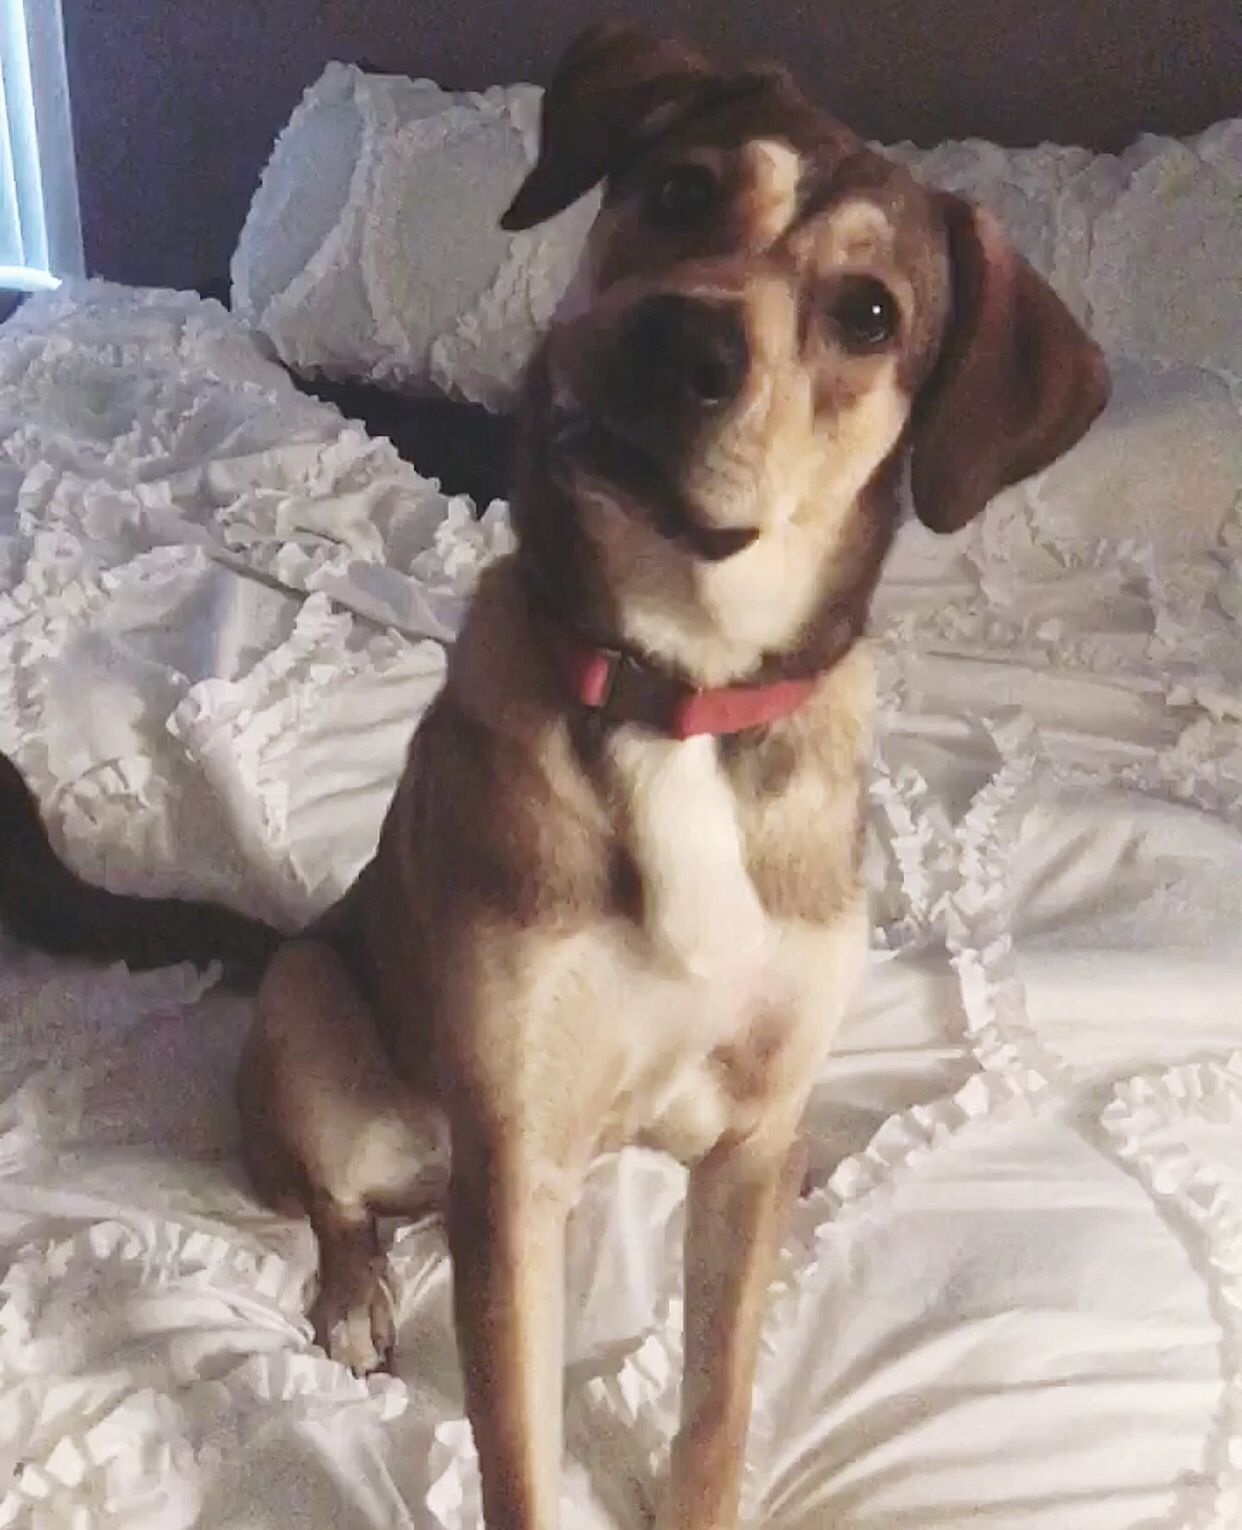

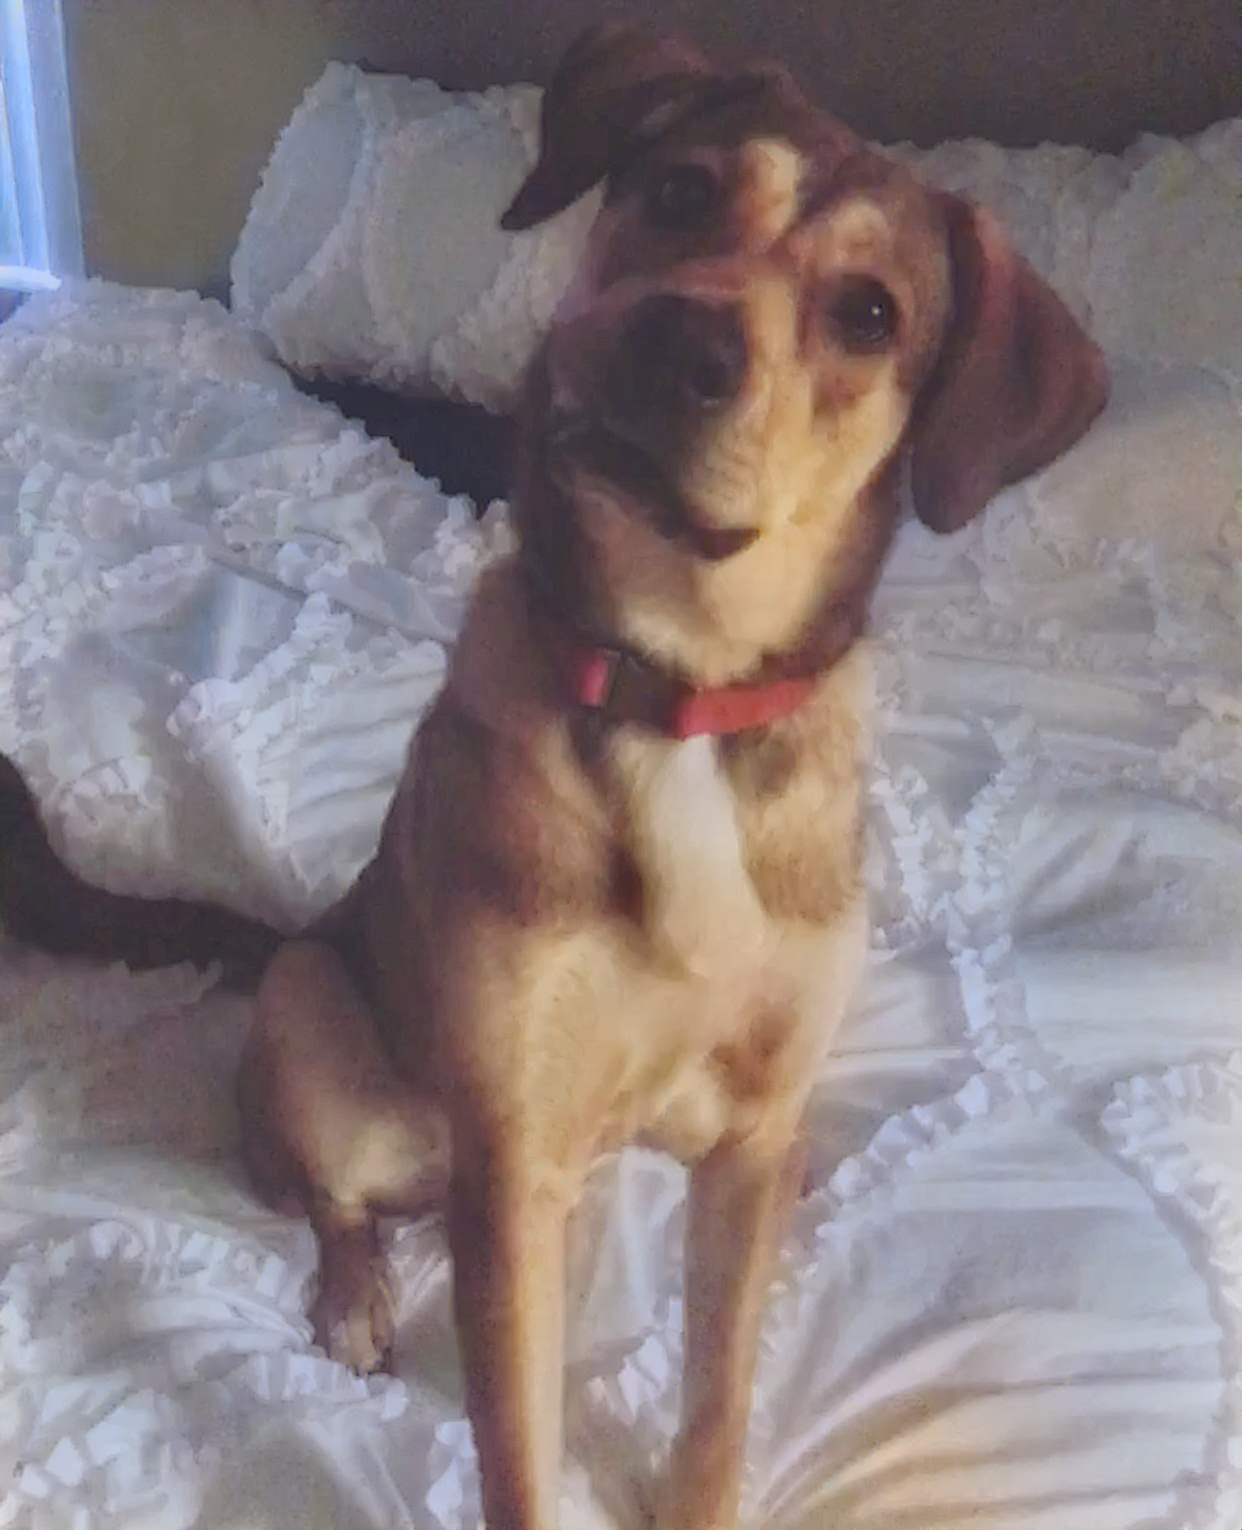

In [25]:
from IPython.display import Image

from IPython.display import Image, display

listOfImageNames = [arguments["content_image_path"], 'best_stylized.png']

print("\n\nOriginal Image and the Edited Image through our model:\n\n")
for imageName in listOfImageNames:
    display(Image(filename=imageName))

In [11]:
# Demo on another image

arguments["content_image_path"] = "./new_dataset/demo_data/5.jpg"
img = Image.open(arguments["content_image_path"]).convert('RGB')
img = np.array(img)
print(img.shape)
arguments["content_seg_path"] = "./new_dataset/segmented_demo_data/2.jpg"
seg = Image.open(arguments["content_seg_path"]).convert('RGB')
seg = np.array(seg)
print(seg.shape)

(338, 600, 3)
(500, 500, 3)


In [12]:
get_best_style()

Checking style: 0
Checking style: 1
Checking style: 2
Checking style: 3
Checking style: 4
Checking style: 5
Checking style: 6
Checking style: 7
Checking style: 8
Checking style: 9
Checking style: 10
Checking style: 11
Checking style: 12
Checking style: 13
Checking style: 14
Checking style: 15
Checking style: 16
Checking style: 17
Checking style: 18
Checking style: 19
Checking style: 20
Checking style: 21
Checking style: 22
Checking style: 23
Checking style: 24
Checking style: 25
Checking style: 26
Checking style: 27
Checking style: 28
Checking style: 29
Checking style: 30
Checking style: 31
Checking style: 32
Checking style: 33
Checking style: 34
Checking style: 35
Checking style: 36
Checking style: 37
Checking style: 38
Checking style: 39
Checking style: 40
Checking style: 41
Checking style: 42
Checking style: 43
Checking style: 44
Checking style: 45
Checking style: 46
Checking style: 47
Checking style: 48
Checking style: 49
Checking style: 50
Checking style: 51
Checking style: 52
Che

In [13]:
edit_image()

2022-12-09 19:47:06.353755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 19:47:06.353985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-12-09 19:47:06.354083: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-12-09 19:47:06.354134: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-12-09 19:47:06.354163: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-12-09 19:47:06.354188: I tensorflow/stream_executor/pl

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that ca

2022-12-09 19:49:02.607949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 19:49:02.608184: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-12-09 19:49:02.608261: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-12-09 19:49:02.608289: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-12-09 19:49:02.608303: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-12-09 19:49:02.608315: I tensorflow/stream_executor/pl

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that ca



Original Image and the Edited Image through our model:




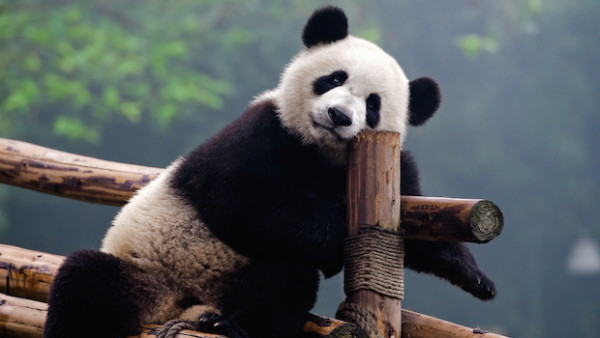

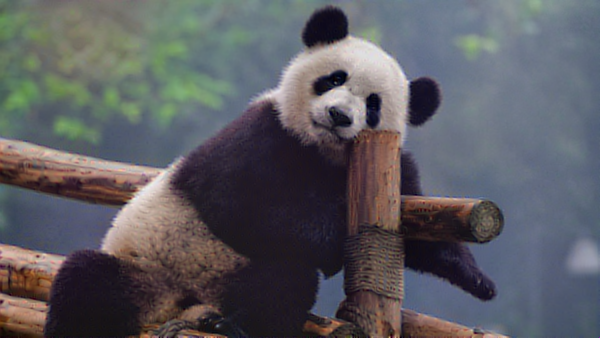

In [14]:
from IPython.display import Image

from IPython.display import Image, display

listOfImageNames = [arguments["content_image_path"], 'best_stylized.png']

print("\n\nOriginal Image and the Edited Image through our model:\n\n")
for imageName in listOfImageNames:
    display(Image(filename=imageName))